In [46]:
import math
import numpy as np
import re

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image

In [47]:
def files_in_folder(folder_path):
  '''
  Returns a list of strings where each entry is a file in the folder_path.
  
  Parameters
  ----------
  
  folder_path : str
     A string to folder for which the file listing is returned.
     
  '''
  files_A = !ls "{folder_path}"
  # The files when listed from Google Drive have a particular format. They are
  # grouped in sets of 4 and have spaces and tabs as delimiters.
  
  # Split the string listing sets of 4 files by tab and space and remove any 
  # empty splits.
  files_B = [list(filter(None, re.split('\t|\s', files))) for files in files_A]
  
  # Concatenate all splits into a single sorted list
  files_C = []
  for element in files_B:
    files_C = files_C + element
  files_C.sort()
  
  return files_C

image_files = files_in_folder('./image_data')

In [48]:
def get_a_v(filename):
    split = filename.split('_')
    a = split[3][1:-4]
    v = split[2][1:]
    return (float(v), float(a))

In [49]:
# load images and parse out accel and velocity
# data = np.array([[np.array(Image.open(f'image_data/{f}').resize((640, 360))), *get_a_v(f)] for f in image_files])
data = np.array([[np.array(Image.open(f'image_data/{f}')), *get_a_v(f)] for f in image_files])

In [50]:
#shuffle dat shiz
np.random.shuffle(data)

In [51]:
X_data = np.stack(data[:, 0])/255
Y_data = np.stack(data[:, 1:])

In [52]:
# keras go brr time
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend
from tensorflow.keras import metrics

In [53]:
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [54]:
# Model def
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(360, 640, 3)))
conv_model.add(layers.MaxPooling2D((3, 3)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((3, 3)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((3, 3)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((3, 3)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(2, activation='linear'))

In [55]:
conv_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 358, 638, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 119, 212, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 117, 210, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 39, 70, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 37, 68, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 22, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 20, 128)      

In [56]:
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 1e-4
conv_model.compile(loss='MSE',
                   optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                   metrics=[metrics.RootMeanSquaredError()])

In [57]:
reset_weights(conv_model)

In [58]:
history_conv = conv_model.fit(X_data, Y_data, 
                              validation_split=VALIDATION_SPLIT, 
                              epochs=20, 
                              batch_size=16)

Train on 662 samples, validate on 166 samples
Epoch 1/20
662/662 [==============================] - 28s 43ms/sample - loss: 0.2873 - root_mean_squared_error: 0.5360 - val_loss: 0.2047 - val_root_mean_squared_error: 0.4525
Epoch 2/20
662/662 [==============================] - 28s 42ms/sample - loss: 0.1743 - root_mean_squared_error: 0.4175 - val_loss: 0.1090 - val_root_mean_squared_error: 0.3302
Epoch 3/20
662/662 [==============================] - 28s 43ms/sample - loss: 0.1050 - root_mean_squared_error: 0.3240 - val_loss: 0.0745 - val_root_mean_squared_error: 0.2729
Epoch 4/20
662/662 [==============================] - 28s 43ms/sample - loss: 0.0865 - root_mean_squared_error: 0.2942 - val_loss: 0.0707 - val_root_mean_squared_error: 0.2658
Epoch 5/20
662/662 [==============================] - 28s 43ms/sample - loss: 0.0814 - root_mean_squared_error: 0.2853 - val_loss: 0.0599 - val_root_mean_squared_error: 0.2448
Epoch 6/20
662/662 [==============================] - 28s 43ms/sample - lo

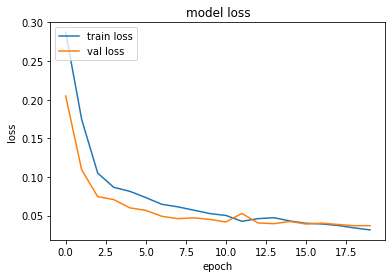

In [59]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

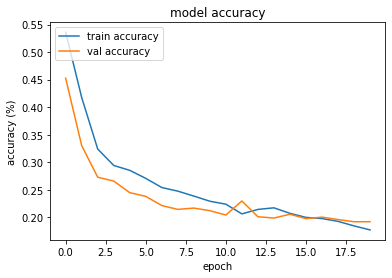

In [60]:
plt.plot(history_conv.history['root_mean_squared_error'])
plt.plot(history_conv.history['val_root_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

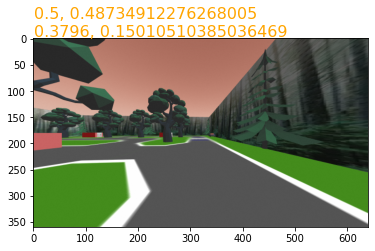

In [66]:
# Display images in the training data set. 
def displayImage(index):
  img = X_data[index]
  
  img_aug = np.expand_dims(img, axis=0)
  y_predict = conv_model.predict(img_aug)[0]
  
  plt.imshow(img)  
  caption = (f'{Y_data[index][0]}, {y_predict[0]}\n' +
             f'{Y_data[index][1]}, {y_predict[1]}')
  plt.text(0.5, 0.5, caption, 
           color='orange', fontsize = 16,
           horizontalalignment='left', verticalalignment='bottom')


# interact(displayImage, 
#         index=ipywidgets.IntSlider(min=0, max=X_dataset_orig.shape[0],
#                                    step=1, value=10))
displayImage(120)

In [62]:
conv_model.save('drive_model')